In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from datetime import datetime
from collections import OrderedDict

In [2]:
import pickle

In [3]:
PATH = Path("/data2/yinterian/multi-task-romain")

In [4]:
gap = "5min"
gap

'5min'

In [5]:
filename = "data_train_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    train = pickle.load(f)

In [6]:
filename = "data_valid_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    valid = pickle.load(f)

In [7]:
train.head()

,subject_id,key,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_HR,prediction_mean_MAP,series,group
0,10013,10013_18,1,87,49,7,3,1,0,1,95.44,55.88,"[[110.1, 0.0, 85.7, 37.1, 55.4], [110.9, 0.0, ...",0
1,10013,10013_19,1,87,49,7,3,1,0,1,107.4,68.4,"[[96.0, 92.0, 106.2, 35.2, 55.9], [101.9, 92.7...",0
2,10013,10013_20,1,87,49,7,3,1,0,1,102.08,68.28,"[[106.2, 94.5, 127.6, 43.6, 69.7], [106.1, 94....",0
3,10013,10013_23,1,87,49,7,3,1,0,1,99.14,86.14,"[[93.0, 93.4, 139.6, 51.0, 80.9], [93.0, 93.8,...",0
4,10013,10013_24,1,87,49,7,3,1,0,1,108.1,69.96,"[[97.5, 94.0, 144.1, 54.4, 86.4], [101.3, 94.5...",0


In [8]:
valid.head()

,subject_id,key,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_HR,prediction_mean_MAP,series,group
1400,11018,11018_103,0,67,47,1,1,0,0,0,57.0333,127.633,"[[58.0, 100.0, 141.0, 122.0, 130.0], [61.0, 10...",1
1401,11018,11018_29,0,67,47,1,1,0,0,0,74.94,71.07,"[[78.0, 97.0, 99.0, 59.0, 72.0], [78.0, 97.0, ...",1
1402,11018,11018_30,0,67,47,1,1,0,0,0,75.24,74.6167,"[[74.0, 97.0, 99.0, 59.0, 72.0], [75.0, 96.0, ...",1
1403,11018,11018_32,0,67,47,1,1,0,0,0,82.29,79.1533,"[[78.0, 96.0, 108.0, 64.0, 78.0], [77.0, 97.0,...",1
1404,11018,11018_33,0,67,47,1,1,0,0,0,80.54,82.64,"[[83.0, 93.0, 113.0, 66.0, 81.0], [82.0, 93.0,...",1


In [9]:
np.unique(train.care_unit.values)

array([1, 2, 3, 5, 6], dtype=object)

In [10]:
train.shape, valid.shape

((59742, 14), (7086, 14))

In [11]:
subject_id_list = np.sort(np.unique(train.subject_id.values))
id2index = {v: k+1 for k,v in enumerate(subject_id_list)}
num_subjects = len(subject_id_list)

In [12]:
num_subjects

2295

## Dataset

In [13]:
def get_mean_std_series(train):
    ss = np.concatenate(train.series.values)
    ss = ss.reshape(-1,5)
    return ss.mean(axis=0), ss.std(axis=0)

In [14]:
def get_mean_std_static(train):
    res = {}
    for name in ["age", "sapsii", "sofa"]:
        values = train[name].values
        res[name] = (values.mean(), values.std())
    res["series"] = get_mean_std_series(train)
    return res

In [15]:
norm_dict = get_mean_std_static(train)
norm_dict 

{'age': (64, 15.073998327645949),
 'sapsii': (33, 14.215114554630107),
 'sofa': (4, 3.7687923741651197),
 'series': (array([ 83.25271123,  93.7286662 , 120.81020051,  58.76277023,
          78.52866913]),
  array([16.10279665, 17.32261077, 21.2893833 , 12.28384779, 14.32805636]))}

In [16]:
care2id = {v:k for k,v in enumerate(np.unique(train.care_unit.values))}
care2id 

{1: 0, 2: 1, 3: 2, 5: 3, 6: 4}

In [17]:
class MultiTask(Dataset):
    def __init__(self, df, norm_dict, id2index, care2id,  k=20, train=True):
        """
        Args:
            df: dataframe with data
            norm_dict: mean and std of all variables to normalize
            
        """
        self.norm_dict = norm_dict
        self.df = df
        self.df["care_unit"] = self.df["care_unit"].apply(lambda x: care2id[x])
        self.names = ["age", "sapsii", "sofa"] ## needs normalization
        self.names_binary = ["gender", "amine", "sedation", "ventilation"]
        self.id2index = id2index
        self.train = train
        self.df_sample = self.pick_a_sample(k)
            
    def pick_a_sample(self, k=20):
        """ Picks sample with the same number of observations per patient"""
        if not self.train: # fix seed for validation and test
            np.random.seed(3)
        sample = self.df.groupby("subject_id", group_keys=False).apply(lambda x: x.sample(k, replace=True))
        sample = sample.copy()
        if self.train:
            self.subject_index = [self.id2index[subject_id] for subject_id in sample.subject_id.values]
            self.random = np.random.choice(2, sample.shape[0], p=[0.1, 0.9])
            self.subject_index = self.subject_index*self.random
        return sample

    def __getitem__(self, index):
        row = self.df_sample.iloc[index,:]
        x_series = (row.series - self.norm_dict["series"][0])/self.norm_dict["series"][1]
        x_cont = [(row[name]-self.norm_dict[name][0])/self.norm_dict[name][1] for name in self.names]
        x_binary = [row[name] for name in self.names_binary]
        subject_index = 0
        if self.train:
            subject_index = self.subject_index[index]
        x_cat = np.array([row["care_unit"], subject_index])
        x_cont = np.array(x_cont + x_binary)
        return x_series, x_cont, x_cat, row["prediction_mean_HR"], row["prediction_mean_MAP"]

    def __len__(self):
        return self.df_sample.shape[0]

In [18]:
train_ds = MultiTask(train, norm_dict, id2index, care2id)
valid_ds = MultiTask(valid, norm_dict, id2index, care2id, train=False)

## Model

In [19]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [20]:
class EventModel1(nn.Module):
    def __init__(self, hidden_size=100, num_units=5):
        super(EventModel1, self).__init__()
        self.embedding1 = nn.Embedding(num_units, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 10 + 1 + 5
        self.linear1 = nn.Linear(7, 10)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(10)

    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x_cont = self.bn1(F.relu(self.linear1(x_cont))) 
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        return self.out1(x), self.out2(x)

In [21]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat1 = []
    ys1 = []
    y_hat2 = []
    ys2 = []
    for x_series, x_cont, x_cat, y1, y2 in valid_dl:
        batch = y1.shape[0]
        x_series = x_series.float().cuda()
        x_cont = x_cont.float().cuda()
        x_cat = x_cat.long().cuda()
        y1 = y1.float().cuda()
        y2 = y2.float().cuda()
        out1, out2 = model(x_series, x_cont, x_cat)
        mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
        mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
        loss = mse_loss1 + mse_loss2
        sum_loss += batch*(loss.item())
        total += batch
        y_hat1.append(out1.view(-1).detach().cpu().numpy())
        ys1.append(y1.view(-1).cpu().numpy())
        y_hat2.append(out2.view(-1).detach().cpu().numpy())
        ys2.append(y2.view(-1).cpu().numpy())
    
    y_hat1 = np.concatenate(y_hat1)
    y_hat2 = np.concatenate(y_hat2)
    ys1 = np.concatenate(ys1)
    ys2 = np.concatenate(ys2)
    r2_1 = metrics.r2_score(ys1, y_hat1)
    r2_2 = metrics.r2_score(ys2, y_hat2)
    return sum_loss/total, r2_1, r2_2

In [22]:
def train_epochs(model, train_ds, optimizer, filename, lr=1e-3, epochs = 30):
    prev_val_r2 = 0
    for i in range(epochs):
        sum_loss1 = 0
        sum_loss2 = 0
        total = 0
        train_ds.pick_a_sample()
        train_dl = DataLoader(train_ds, batch_size=5000, shuffle=True)
        for x_series, x_cont, x_cat, y1, y2 in train_dl:
            model.train()
            x_series = x_series.float().cuda()
            x_cont = x_cont.float().cuda()
            x_cat = x_cat.long().cuda()
            y1 = y1.float().cuda()
            y2 = y2.float().cuda()
            out1, out2 = model(x_series, x_cont, x_cat)
            mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
            mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
            loss = mse_loss1 + mse_loss2
            sum_loss1 += len(y1) * mse_loss1.item()
            sum_loss2 += len(y1) * mse_loss2.item()
            total += len(y1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if i % 1 == 0:
            val_loss, val_r2_1, val_r2_2 = val_metrics(model, valid_dl)
            print("\tTrain loss: {:.3f} {:.3f} valid loss: {:.3f} valid r2 hr {:.3f} valid r2 map {:.3f}".format(
                sum_loss1/total, sum_loss2/total, val_loss, val_r2_1, val_r2_2))
            
        if val_r2_1 > prev_val_r2:
            prev_val_r2 = val_r2_1
            if val_r2_1 > 0.7:
                path = "{0}/models/{1}_r2_{2:.0f}_{3:.0f}.pth".format(PATH, filename, 100*val_r2_1, 100*val_r2_2) 
                save_model(model, path)
                print(path)

In [23]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [24]:
model = EventModel1().cuda()

In [25]:
val_metrics(model, valid_dl)

(13482.621754581767, -27.68109129134414, -33.347568094222666)

In [26]:
# 0s in training
model = EventModel1().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model1_patient", epochs=15)

	Train loss: 5195.507 4429.789 valid loss: 3450.983 valid r2 hr -7.066 valid r2 map -6.761
	Train loss: 937.666 660.969 valid loss: 647.213 valid r2 hr -0.186 valid r2 map -0.921
	Train loss: 365.126 296.718 valid loss: 741.749 valid r2 hr -0.712 valid r2 map -0.699
	Train loss: 207.239 94.101 valid loss: 183.896 valid r2 hr 0.490 valid r2 map 0.701
	Train loss: 107.485 78.883 valid loss: 139.494 valid r2 hr 0.664 valid r2 map 0.700
	Train loss: 64.245 54.253 valid loss: 130.785 valid r2 hr 0.745 valid r2 map 0.634
/data2/yinterian/multi-task-romain/models/model1_patient_r2_75_63.pth
	Train loss: 45.459 49.663 valid loss: 114.675 valid r2 hr 0.760 valid r2 map 0.702
/data2/yinterian/multi-task-romain/models/model1_patient_r2_76_70.pth
	Train loss: 39.835 42.254 valid loss: 90.910 valid r2 hr 0.809 valid r2 map 0.766
/data2/yinterian/multi-task-romain/models/model1_patient_r2_81_77.pth
	Train loss: 35.553 38.368 valid loss: 86.744 valid r2 hr 0.817 valid r2 map 0.777
/data2/yinterian/mu

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer,filename="model1", epochs=20)

	Train loss: 21.742 24.150 valid loss: 52.532 valid r2 hr 0.888 valid r2 map 0.866
/data2/yinterian/multi-task-romain/models/model1_r2_89_87.pth
	Train loss: 16.358 19.778 valid loss: 40.725 valid r2 hr 0.913 valid r2 map 0.897
/data2/yinterian/multi-task-romain/models/model1_r2_91_90.pth
	Train loss: 14.122 16.895 valid loss: 34.320 valid r2 hr 0.927 valid r2 map 0.912
/data2/yinterian/multi-task-romain/models/model1_r2_93_91.pth
	Train loss: 17.706 19.842 valid loss: 31.056 valid r2 hr 0.937 valid r2 map 0.916
/data2/yinterian/multi-task-romain/models/model1_r2_94_92.pth
	Train loss: 11.397 14.482 valid loss: 27.272 valid r2 hr 0.946 valid r2 map 0.925
/data2/yinterian/multi-task-romain/models/model1_r2_95_92.pth
	Train loss: 10.576 13.584 valid loss: 24.942 valid r2 hr 0.949 valid r2 map 0.933
/data2/yinterian/multi-task-romain/models/model1_r2_95_93.pth
	Train loss: 9.819 12.988 valid loss: 22.978 valid r2 hr 0.956 valid r2 map 0.935
/data2/yinterian/multi-task-romain/models/model1

### Model 2

In [31]:
class EventModel2(nn.Module):
    def __init__(self, hidden_size=100, num_units=6):
        super(EventModel2, self).__init__()
        self.embedding1 = nn.Embedding(num_units, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 1 + 5 + 7
        self.linear1 = nn.Linear(self.num, self.num)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(self.num)
        
    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        x = self.bn1(F.relu(self.linear1(x)))
        return self.out1(x), self.out2(x)

In [29]:
model = EventModel2().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model2", epochs=15)

	Train loss: 6191.700 5543.153 valid loss: 4940.072 valid r2 hr -9.691 valid r2 map -11.325
	Train loss: 1419.165 1277.304 valid loss: 1714.941 valid r2 hr -2.423 valid r2 map -3.689
	Train loss: 521.641 507.940 valid loss: 196.272 valid r2 hr 0.595 valid r2 map 0.482
	Train loss: 95.000 102.962 valid loss: 257.781 valid r2 hr 0.367 valid r2 map 0.463
	Train loss: 51.205 52.618 valid loss: 97.898 valid r2 hr 0.915 valid r2 map 0.575
/data2/yinterian/multi-task-romain/models/model2_r2_92_57.pth
	Train loss: 31.816 36.475 valid loss: 22.789 valid r2 hr 0.960 valid r2 map 0.929
/data2/yinterian/multi-task-romain/models/model2_r2_96_93.pth
	Train loss: 16.062 19.079 valid loss: 19.409 valid r2 hr 0.964 valid r2 map 0.943
/data2/yinterian/multi-task-romain/models/model2_r2_96_94.pth
	Train loss: 9.765 12.008 valid loss: 21.577 valid r2 hr 0.965 valid r2 map 0.929
/data2/yinterian/multi-task-romain/models/model2_r2_97_93.pth
	Train loss: 8.064 10.762 valid loss: 20.647 valid r2 hr 0.963 vali

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model2", epochs=20)

	Train loss: 29.093 34.908 valid loss: 119.992 valid r2 hr 0.771 valid r2 map 0.657
/data2/yinterian/multi-task-romain/models/model2_r2_77_66.pth
	Train loss: 13.057 15.308 valid loss: 36.282 valid r2 hr 0.922 valid r2 map 0.908
/data2/yinterian/multi-task-romain/models/model2_r2_92_91.pth
	Train loss: 9.540 11.968 valid loss: 19.159 valid r2 hr 0.969 valid r2 map 0.938
/data2/yinterian/multi-task-romain/models/model2_r2_97_94.pth
	Train loss: 7.357 10.090 valid loss: 16.732 valid r2 hr 0.974 valid r2 map 0.943
/data2/yinterian/multi-task-romain/models/model2_r2_97_94.pth
	Train loss: 7.026 9.448 valid loss: 15.284 valid r2 hr 0.975 valid r2 map 0.950
/data2/yinterian/multi-task-romain/models/model2_r2_98_95.pth
	Train loss: 6.548 8.765 valid loss: 15.336 valid r2 hr 0.974 valid r2 map 0.951
	Train loss: 6.543 8.747 valid loss: 14.753 valid r2 hr 0.977 valid r2 map 0.951
/data2/yinterian/multi-task-romain/models/model2_r2_98_95.pth
	Train loss: 6.104 8.669 valid loss: 14.135 valid r2 h

In [31]:
train_epochs(model, train_ds, optimizer, filename="model2", epochs=10)

	Train loss: 5.848 7.977 valid loss: 14.660 valid r2 hr 0.977 valid r2 map 0.951
/data2/yinterian/multi-task-romain/models/model2_r2_98_95.pth
	Train loss: 5.696 7.827 valid loss: 14.806 valid r2 hr 0.976 valid r2 map 0.952
	Train loss: 6.034 8.107 valid loss: 16.833 valid r2 hr 0.970 valid r2 map 0.948
	Train loss: 5.729 7.845 valid loss: 16.640 valid r2 hr 0.972 valid r2 map 0.947
	Train loss: 5.905 8.009 valid loss: 14.851 valid r2 hr 0.978 valid r2 map 0.949
/data2/yinterian/multi-task-romain/models/model2_r2_98_95.pth
	Train loss: 5.354 7.799 valid loss: 14.490 valid r2 hr 0.978 valid r2 map 0.951
/data2/yinterian/multi-task-romain/models/model2_r2_98_95.pth
	Train loss: 5.961 7.699 valid loss: 15.103 valid r2 hr 0.974 valid r2 map 0.953
	Train loss: 5.317 7.423 valid loss: 16.778 valid r2 hr 0.969 valid r2 map 0.951
	Train loss: 5.418 7.532 valid loss: 15.748 valid r2 hr 0.972 valid r2 map 0.952
	Train loss: 5.528 7.475 valid loss: 15.005 valid r2 hr 0.977 valid r2 map 0.950


## Model 3

In [26]:
class EventModel3(nn.Module):
    def __init__(self, hidden_size=100, num2=50, num_units=5):
        super(EventModel3, self).__init__()
        self.embedding1 = nn.Embedding(num_units, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num1 = hidden_size + 1 + 5 + 7
        self.num2 = num2
        self.linear1 = nn.Linear(self.num1, self.num2)
        self.linear2 = nn.Linear(self.num2, self.num2)
        self.out1 = nn.Linear(self.num2, 1)
        self.out2 = nn.Linear(self.num2, 1)
        self.bn1 = nn.BatchNorm1d(self.num2)
        self.bn2 = nn.BatchNorm1d(self.num2)
        
    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))
        return self.out1(x), self.out2(x)

In [27]:
model = EventModel3().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model3", epochs=15)

	Train loss: 6885.198 6141.245 valid loss: 14296.170 valid r2 hr -28.772 valid r2 map -36.329
	Train loss: 5649.875 4997.138 valid loss: 10450.174 valid r2 hr -20.288 valid r2 map -26.963
	Train loss: 3251.571 2747.373 valid loss: 4037.307 valid r2 hr -7.317 valid r2 map -9.671
	Train loss: 747.598 540.846 valid loss: 190.294 valid r2 hr 0.545 valid r2 map 0.587
	Train loss: 76.875 115.111 valid loss: 143.595 valid r2 hr 0.738 valid r2 map 0.572
/data2/yinterian/multi-task-romain/models/model3_r2_74_57.pth
	Train loss: 124.337 131.782 valid loss: 20.814 valid r2 hr 0.959 valid r2 map 0.942
/data2/yinterian/multi-task-romain/models/model3_r2_96_94.pth
	Train loss: 14.158 19.591 valid loss: 62.103 valid r2 hr 0.905 valid r2 map 0.789
	Train loss: 21.620 29.566 valid loss: 19.124 valid r2 hr 0.971 valid r2 map 0.934
/data2/yinterian/multi-task-romain/models/model3_r2_97_93.pth
	Train loss: 8.930 12.403 valid loss: 23.069 valid r2 hr 0.963 valid r2 map 0.923
	Train loss: 9.632 12.969 valid

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model3", epochs=15)

	Train loss: 29.170 27.849 valid loss: 73.702 valid r2 hr 0.866 valid r2 map 0.780
/data2/yinterian/multi-task-romain/models/model3_r2_87_78.pth
	Train loss: 12.015 16.165 valid loss: 22.447 valid r2 hr 0.964 valid r2 map 0.926
/data2/yinterian/multi-task-romain/models/model3_r2_96_93.pth
	Train loss: 8.357 11.164 valid loss: 21.433 valid r2 hr 0.965 valid r2 map 0.930
/data2/yinterian/multi-task-romain/models/model3_r2_97_93.pth
	Train loss: 7.504 9.814 valid loss: 15.032 valid r2 hr 0.977 valid r2 map 0.949
/data2/yinterian/multi-task-romain/models/model3_r2_98_95.pth
	Train loss: 6.768 9.472 valid loss: 14.164 valid r2 hr 0.979 valid r2 map 0.951
/data2/yinterian/multi-task-romain/models/model3_r2_98_95.pth
	Train loss: 6.480 9.068 valid loss: 13.903 valid r2 hr 0.979 valid r2 map 0.952
	Train loss: 6.636 8.851 valid loss: 14.117 valid r2 hr 0.978 valid r2 map 0.952
	Train loss: 6.411 8.843 valid loss: 14.475 valid r2 hr 0.978 valid r2 map 0.951
	Train loss: 6.294 8.637 valid loss: 

## Calibration plot

In [29]:
path = PATH/"models/model3_r2_98_95.pth"
model = EventModel3().cuda()
load_model(model, path)

In [30]:
# external data
filename = "data_validation_5min.pickle"
with open(PATH/filename, 'rb') as f:
    test_ext = pickle.load(f)

In [31]:
filename = "data_test_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    test = pickle.load(f)
print(filename)

data_test_5min.pickle


In [32]:
care2id

{1: 0, 2: 1, 3: 2, 5: 3, 6: 4}

In [33]:
test_ds = MultiTask(test, norm_dict, id2index, care2id, k=13, train=False)
test_ext_ds = MultiTask(test_ext, norm_dict, id2index, care2id, k=13, train=False)
test.shape, len(test_ds), len(test_ext_ds)

((8233, 14), 3757, 702)

In [34]:
test_dl = DataLoader(test_ds, batch_size=len(test_ds))
test_ext_dl = DataLoader(test_ext_ds, batch_size=len(test_ext_ds))

In [35]:
val_metrics(model, test_dl)

(16.702987670898438, 0.9750842279071364, 0.9499048382493396)

In [36]:
val_metrics(model, test_ext_dl)

(101.68622589111328, 0.8938414040295823, 0.8166751889489203)

In [69]:
x_series, x_cont, x_cat, y1, y2 = next(iter(test_ext_dl))

In [70]:
x_series.shape, x_cont.shape, x_cat.shape

(torch.Size([702, 30, 5]), torch.Size([702, 7]), torch.Size([702, 2]))

In [71]:
batch = y1.shape[0]
x_series = x_series.float().cuda()
x_cont = x_cont.float().cuda()
x_cat = x_cat.long().cuda()
y1 = y1.float().cuda()
y2 = y2.float().cuda()
out1, out2 = model(x_series, x_cont, x_cat)
mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
loss = mse_loss1 + mse_loss2
        
y_hat1 = out1.view(-1).detach().cpu().numpy()
ys1 = y1.view(-1).cpu().numpy()
y_hat2 = out2.view(-1).detach().cpu().numpy()
ys2 =(y2.view(-1).cpu().numpy())

In [74]:
x_series[258,:]

tensor([[-0.8230,  0.1888, -1.9639,  0.1007, -0.5254],
        [-0.8230,  0.1888, -1.9639,  0.1007, -0.5254],
        [-0.6988,  0.1888, -1.8700,  0.1821, -0.3859],
        [-0.6988,  0.1888, -1.8700,  0.2635, -0.3161],
        [-0.8230,  0.1888, -1.8700,  0.2635, -0.3161],
        [-0.6988,  0.1888, -1.8230,  0.4264, -0.2463],
        [-0.7609,  0.1888, -1.8230,  0.4264, -0.2463],
        [-0.6988,  0.1888, -1.9169,  0.3449, -0.3161],
        [-0.6988,  0.1888, -1.9169,  0.2635, -0.3859],
        [-0.6988,  0.1888, -1.9169,  0.2635, -0.3859],
        [-0.4504,  0.2466,  0.5256,  2.2173,  1.3590],
        [-0.1399,  0.0734, -1.6821,  0.7520,  0.0329],
        [-0.5125,  0.0734, -1.9169,  0.3449, -0.3161],
        [-0.6367,  0.1311, -1.9639,  0.2635, -0.3859],
        [-0.3262,  0.1888, -2.0109,  0.2635, -0.3859],
        [-0.0778,  0.1888, -1.9639,  0.3449, -0.3859],
        [-0.4504,  0.1888, -2.0109,  0.2635, -0.3859],
        [-0.5746,  0.1888, -2.0109,  0.2635, -0.4557],
        [-

In [79]:
ys1[:20]

array([92.8, 89.2, 77.4, 93. , 92.8, 70.4, 74.6, 92.8, 81. , 93. , 70. ,
       83.6, 61.2, 88.4, 80. , 77.2, 76.4, 76.4, 80. , 63.4],
      dtype=float32)

In [73]:
np.argwhere(np.isnan(ys1))

array([[258],
       [521]])

In [37]:
val_metrics(model, test_ext_dl)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [58]:
def predict_one_batch(model, dl):
    for x_series, x_cont, x_cat, y1, y2 in dl:
        x_series = x_series.float().cuda()
        x_cont = x_cont.float().cuda()
        x_cat = x_cat.long().cuda()
        y1 = y1.float().cuda()
        y2 = y2.float().cuda()
        out1, out2 = model(x_series, x_cont, x_cat)
    return out1.detach().cpu().numpy(), out2.detach().cpu().numpy(), y1.detach().cpu().numpy(), y2.detach().cpu().numpy()

In [59]:
out1, out2, y1, y2 = predict_one_batch(model, test_dl)

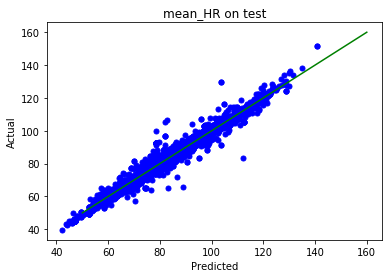

In [60]:
x = np.linspace(50, 160, 1000)
plt.plot(out1, y1, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_HR on test")
plt.plot(x, x, '-g')
plt.show()

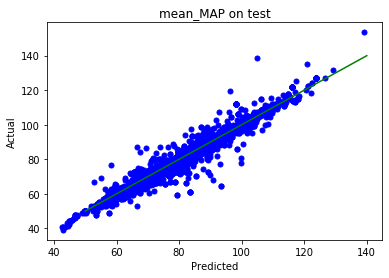

In [61]:
x = np.linspace(50, 140, 1000)
plt.plot(out2, y2, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_MAP on test")
plt.plot(x, x, '-g')
plt.show()